# AML - Training

In [4]:
## Check core SDK version number
import azureml.core
import mlflow
import os

from azureml.core import (Datastore, Dataset, Environment, Experiment, ScriptRunConfig,
                          Workspace)
from azureml.core.authentication import InteractiveLoginAuthentication
from IPython.display import display



print("[INFO] SDK version:", azureml.core.VERSION)

## due to diferent tenant -> typically customer tenant
# interactive_auth = InteractiveLoginAuthentication(tenant_id="72f988bf-86f1-41af-91ab-2d7cd011db47")

ws = Workspace.from_config()
print("[SUCCESS] LOGGED IN: ",ws.name, ws.resource_group, ws.location, ws.subscription_id, sep=' @ ')

## set mlflow backend to AML
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

print("[INFO] MLFlow wired to AML:", "experiments.azureml.net" in mlflow.get_tracking_uri())

[INFO] SDK version: 1.17.0
[SUCCESS] LOGGED IN:  @ mlops-demo @ mlops-rg @ westeurope @ 6ee947fa-0d77-4915-bf68-4a83a8bec2a4
[INFO] MLFlow wired to AML: True


## Config

In [5]:
aml_compute = "aml-cluster"
aml_ds = "aml_data"# "mmaadlsgen2_test"
# aml_dset = 'noa_weather'
# aml_dset = "oj_sample_data"
aml_dset = "diabetes_multiple"
aml_experiment = "mlflow-azureml"
loc_data = "data/demo_data"

In [6]:
## set the datastore
ds = ws.datastores[aml_ds]
print(f"[INFO] Datastore: {ds.name}, type: {ds.datastore_type}")

[INFO] Datastore: aml_data, type: AzureBlob


##  Data Prep

In [7]:
wtds = Dataset.get_by_name(ws, name=aml_dset)
# wtds = Dataset.get_by_name(ws, name='noa_weather')
pdf = wtds.to_pandas_dataframe()
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
AGE    442 non-null int64
SEX    442 non-null int64
BMI    442 non-null float64
BP     442 non-null float64
S1     442 non-null int64
S2     442 non-null float64
S3     442 non-null float64
S4     442 non-null float64
S5     442 non-null float64
S6     442 non-null int64
Y      442 non-null int64
dtypes: float64(6), int64(5)
memory usage: 38.1 KB


In [5]:
# !pip install seaborn

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

plt.style.use('bmh')

In [10]:
pdf.columns

Index(['AGE', 'SEX', 'BMI', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'Y'], dtype='object')

In [11]:
# target = "temperature" # diabetes
target = 'Y'

categorical_features_list = ['SEX', target]
quantitative_features_list = ['AGE', 'BMI', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', target]


In [12]:
cols_to_drop = [] # or empty
cols_at_end = [target]

In [13]:
pdf.drop(cols_to_drop,axis=1, inplace=True)

Let's just remove [] and the features with 30% or less NaN values

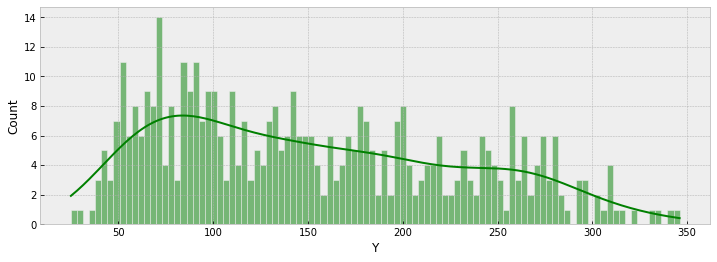

In [14]:
# print(df[target].describe())
plt.figure(figsize=(12, 4))
sns.histplot(pdf[target], color='g', bins=100, kde=True);

In [15]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(pdf, test_size=0.2, random_state=223)

print(f'train:{train.shape[0]} \ntest: {test.shape[0]}')

# final_df.to_csv("./data/taxi_final_df.csv", index=False)
# train.to_csv("./data/taxi_final_df_train.csv", index=False)
# test.to_csv("./data/taxi_final_df_test.csv", index=False)

train:353 
test: 89


## Training Pipeline

In [8]:
mlflow.set_experiment(aml_experiment)

In [9]:
experiment = Experiment(ws, aml_experiment)

#### Define RunConfig for the compute
We will also use `pandas`, `scikit-learn` and `automl`, `pyarrow` for the pipeline steps. Defining the `runconfig` for that.

In [16]:
from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies

# Create a new runconfig object
aml_run_config = RunConfiguration()

# Use the aml_compute you created above. 
aml_run_config.target = aml_compute

# Enable Docker
aml_run_config.environment.docker.enabled = True

# Use conda_dependencies.yml to create a conda environment in the Docker image for execution
aml_run_config.environment.python.user_managed_dependencies = False

# Specify CondaDependencies obj, add necessary packages
aml_run_config.environment.python.conda_dependencies = CondaDependencies.create(
    conda_packages=['scikit-learn','packaging'], 
    pip_packages=['azureml-sdk', 
                    'pyarrow',
                    'pandas==1.1.0',
                    'azureml-dataprep[pandas,fuse]',
                    'scikit-learn==0.22.2.post1',
                    'azureml-mlflow',
                    'lightgbm',
                    'joblib'
                 ])

print ("Run configuration created.")


Run configuration created.


In [17]:
from azureml.pipeline.core import PipelineData
from azureml.pipeline.steps import PythonScriptStep

train_model_folder = "code/train/diabetes"

print('Train script is in {}.'.format(os.path.realpath(train_model_folder)))

# output_data = PipelineData("xxx", datastore=default_store).as_dataset()


# test train split step creation
# See the train_test_split.py for details about input and output
trainStep = PythonScriptStep(
    name="Train Model",
    script_name="train.py", 
    arguments=["--myarg", 111],
#     inputs=[output_split_train.parse_parquet_files(file_extension=None)],
    inputs=[wtds.as_named_input('data')],
#     outputs=[output_data],
    compute_target=aml_compute,
    runconfig = aml_run_config,
    source_directory=train_model_folder,
    allow_reuse=False
)

print("trainStep created.")

Train script is in /mnt/batch/tasks/shared/LS_root/mounts/clusters/ntb-dev2/code/Users/mimarusa/_DEMO_/azureml-demos/code/train/diabetes.
trainStep created.


#### Build and run the pipeline

In [18]:
from azureml.pipeline.core import Pipeline
from azureml.widgets import RunDetails

pipeline_steps = [trainStep]

pipeline = Pipeline(workspace = ws, steps=pipeline_steps)
print("Pipeline is built.")

pipeline_run = experiment.submit(pipeline, regenerate_outputs=False)

# pipeline.validate()

print("Pipeline submitted for execution.")

Pipeline is built.
Created step Train Model [410cfca6][e4c66e03-e4c4-490c-81f4-ba38734c41d9], (This step will run and generate new outputs)
Submitted PipelineRun 2607ec16-1c9c-4b77-a20c-62b2ad1db82e
Link to Azure Machine Learning Portal: https://ml.azure.com/experiments/mlflow-azureml/runs/2607ec16-1c9c-4b77-a20c-62b2ad1db82e?wsid=/subscriptions/6ee947fa-0d77-4915-bf68-4a83a8bec2a4/resourcegroups/mlops-rg/workspaces/mlops-demo
Pipeline submitted for execution.


In [19]:
RunDetails(pipeline_run).show()

_PipelineWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', …

In [21]:
# pipeline_run.get_all_logs()

In [22]:
published_pipeline = pipeline_run.publish_pipeline(
    name="Diabetes Training AML Pipeline", description="training pipeline", version="1.0")

published_pipeline

Name,Id,Status,Endpoint
Diabetes Training AML Pipeline,f23dfc9e-8ea1-4de8-9a3a-dc337425dd79,Active,REST Endpoint


In [24]:
from azureml.pipeline.core import Pipeline, PublishedPipeline
published_pipelines = PublishedPipeline.list(ws)
for published_pipeline in  published_pipelines:
    print(f"{published_pipeline.name},'{published_pipeline.id}'")

Diabetes Training AML Pipeline,'f23dfc9e-8ea1-4de8-9a3a-dc337425dd79'
Batch Scoring demo 10-26-2020-12-33,'9417fa1b-df60-466c-b7cc-298e437a1af3'
Batch Scoring demo 10-26-2020-12-27,'f583d9ea-e197-4a75-b2c7-c1bd65af13c1'
Sample 1: Regression - Automobile Price Prediction (Basic)-batch inference 10-02-2020-02-16,'187bafaf-e858-4701-afe6-29d6619dc25a'
Diabetes_Parallel_Batch_Pipeline,'b337166e-255f-4671-810a-4f9e1e663cc3'
Diabetes_Training_Pipeline,'ec05aacf-4c0b-46d5-a6ba-d30fc877a3c5'
diabetes-Training-Pipeline,'c430f2dc-96d9-4e3e-8825-34ae27067d16'


### Explore the results

In [ ]:
# Before we proceed we need to wait for the run to complete.
pipeline_run.wait_for_completion(show_output=False)

# functions to download output to local and fetch as dataframe
def get_download_path(download_path, output_name):
    output_folder = os.listdir(download_path + '/azureml')[0]
    path =  download_path + '/azureml/' + output_folder + '/' + output_name
    return path

def fetch_df(step, output_name):
    output_data = step.get_output_data(output_name)    
    download_path = './outputs/' + output_name
    output_data.download(download_path, overwrite=True)
    df_path = get_download_path(download_path, output_name) + '/processed.parquet'
    return pd.read_parquet(df_path)

In [ ]:
green_cleanse_step = pipeline_run.find_step_run(cleansingStepGreen.name)[0]
yellow_cleanse_step = pipeline_run.find_step_run(cleansingStepYellow.name)[0]

cleansed_green_df = fetch_df(green_cleanse_step, cleansed_green_data.name)
cleansed_yellow_df = fetch_df(yellow_cleanse_step, cleansed_yellow_data.name)

display(cleansed_green_df.head(5))
display(cleansed_yellow_df.head(5))

## Training on AML Compute

In [16]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

compute_target = ComputeTarget(workspace=ws, name=aml_compute)
# Use the 'status' property to get a detailed status for the current cluster. 
cts = compute_target.status.serialize()
print(f'Found existing compute target: {aml_compute}\n({"cluster is running" if (int(cts["currentNodeCount"])>0) else "cluster is idle"}) currentNodeCount: {cts["currentNodeCount"]}, vmPriority: {cts["vmPriority"]}, vmSize: {cts["vmSize"]}')

Found existing compute target: aml-cluster
(cluster is idle) currentNodeCount: 0, vmPriority: Dedicated, vmSize: STANDARD_D2_V2


In [17]:
import os
project_folder = "code/train/diabetes"

if not os.path.exists(project_folder):
    os.makedirs(project_folder)
else:
    print(f"folder '{project_folder}' aready there")

folder 'code/train/diabetes' aready there


In [18]:
wtds = Dataset.get_by_name(ws, name=aml_dset)

In [19]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

conda_env = Environment('conda-env')
conda_env.python.conda_dependencies = CondaDependencies.create(pip_packages=['azureml-sdk',
                                                                             'azureml-dataprep[pandas,fuse]',
                                                                             'scikit-learn==0.22.2.post1',
                                                                             'azureml-mlflow',
                                                                             'lightgbm',
                                                                            'joblib'])

In [20]:
from azureml.core import ScriptRunConfig

src = ScriptRunConfig(source_directory=project_folder, 
                      script='train.py', 
                      arguments =[wtds.as_named_input('data')])

src.run_config.framework = 'python'
src.run_config.environment = conda_env
src.run_config.target = compute_target.name
# src.run_config.data_references = {ds.name: dr}

In [21]:
run = experiment.submit(config=src)

NameError: name 'experiment' is not defined

In [22]:
from azureml.widgets import RunDetails
RunDetails(run).show()

NameError: name 'run' is not defined